In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms as transforms
import dataset
import torch
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
from sklearn import metrics
import time

In [2]:
transform = transforms.Compose([
    # to-tensor
    transforms.ToTensor(),
    # resize
    transforms.Resize(128),
    # center-crop
    transforms.CenterCrop(128),
    # normalize
    transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010]),
])

In [3]:
incidents = dataset.IncidentsDataset("Incidents-subset", transform=transform)

In [4]:
train_indices, test_indices, _, _ = train_test_split(range(incidents.__len__()), incidents.targets, stratify=incidents.targets, test_size=.3)

In [5]:
len(train_indices), len(test_indices), incidents.__len__()

(4902, 2102, 7004)

In [6]:
batch_size = 32

train_split = Subset(incidents, train_indices)
test_split = Subset(incidents, test_indices)

train_loader = DataLoader(train_split, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_split, batch_size=batch_size)


In [7]:
dataloader = DataLoader(incidents, batch_size=batch_size, shuffle=True)

In [8]:
nSamples = incidents.__len__()
nClasses = len(incidents.labels)
imgShape = incidents.__getitem__(0)[0].shape

print("Number of samples: ", nSamples)
print("Number of classes: ", nClasses)
print("Shape of an image: ", imgShape)

Number of samples:  7004
Number of classes:  12
Shape of an image:  torch.Size([3, 128, 128])


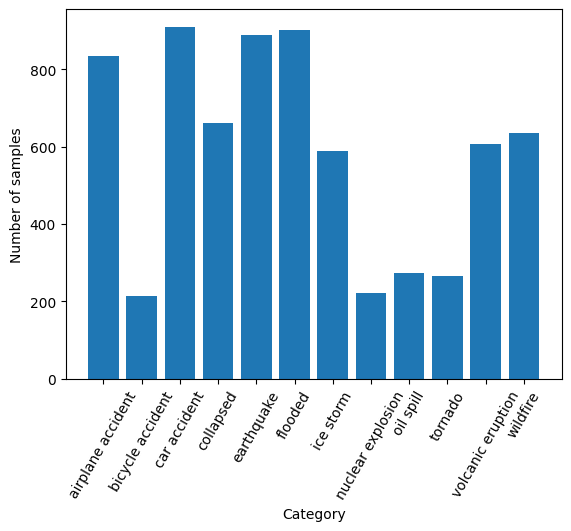

In [9]:
target, counts = np.unique(incidents.targets, return_counts=True)

_, ax = plt.subplots()

ax.bar(incidents.labels[target], counts) #, width=1, edgecolor="white", linewidth=.7)
plt.ylabel("Number of samples")
plt.xlabel("Category")
plt.xticks(rotation=60)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

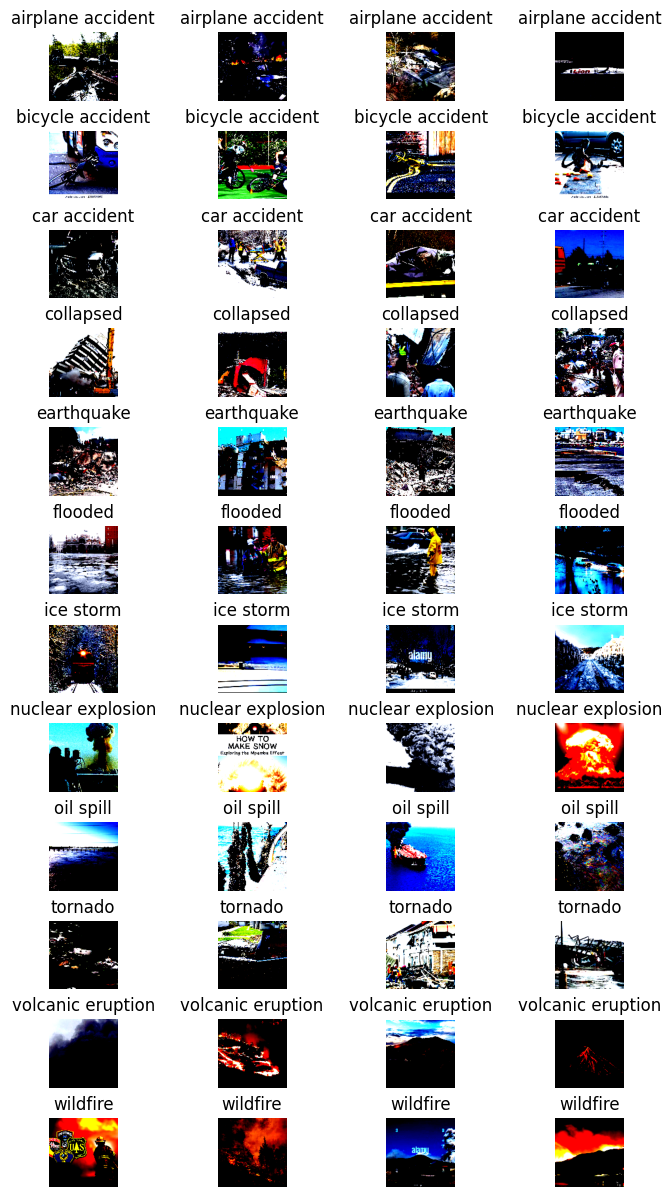

In [10]:
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(15, 15))
grid = ImageGrid(fig, 111, nrows_ncols=(nClasses, 4), axes_pad=(1, .3))

images = []

for n in np.arange(nClasses):
    for i in range(4):
        img = incidents.get_item_with_target(n, i)
        idx = n*4+i
        grid[idx].imshow(img.permute(1, 2, 0))
        grid[idx].set_title(incidents.labels[n])
        grid[idx].axis('off')

In [26]:
# start=time.time()
# epochs = 1
# model.train()  # Put the network in train mode

# for epoch in range(0,epochs):

#   for i, (x_batch, y_batch) in enumerate(train_loader):
#     x_batch = x_batch.to(device)  # Move the data to the device that is used
#     y_batch = y_batch.type(torch.LongTensor) # <---- Here (casting)
#     y_batch = y_batch.to(device)
    
#     # Compute prediction and loss
#     y_pred = model(x_batch)
#     loss = criterion(y_pred, y_batch)

#     # Backpropagation
#     optimizer.zero_grad()  # Set all currenly stored gradients to zero 
#     loss.backward()
#     optimizer.step()

#     # Compute relevant metrics
#     y_pred_max = torch.argmax(y_pred, dim=1)  # Get the labels with highest output probability
#     correct = torch.sum(torch.eq(y_pred_max, y_batch)).item()  # Count how many are equal to the true labels
#     elapsed = time.time() - start  # Keep track of how much time has elapsed

#     # Show progress every 20 batches 
#     if not i % 20:
#       print(f'epoch: {epoch}, time: {elapsed:.3f}s, loss: {loss.item():.3f}, train accuracy: {correct / batch_size:.3f}')

      
    

In [26]:
from tqdm import tqdm

def train_model(model, num_epochs, train_loader, test_loader, criterion, optimizer):
    start = time.time()
    accuracy_history = {'train': [], 'test': []}
    loss_history = {'train': [], 'test': []}

    for epoch in range(num_epochs):
        print(f"Epoch: {epoch + 1}/{num_epochs}")

        running_loss_train, running_loss_test = 0.0, 0.0
        running_corrects_train, running_corrects_test = 0, 0

        print("Training...")
        model.train()  # Put the network in train mode
        for i, (x_batch, y_batch) in enumerate(tqdm(train_loader)):
            x_batch = x_batch.to(device)  # Move the data to the device that is used
            y_batch = y_batch.type(torch.LongTensor) # <---- Here (casting)
            y_batch = y_batch.to(device)

            # Compute prediction and loss
            output = model(x_batch)
            loss_train = criterion(output, y_batch)

            # Backpropagation
            optimizer.zero_grad()  # Set all currenly stored gradients to zero
            loss_train.backward()
            optimizer.step()

            # Compute relevant metrics
            _, preds = torch.max(output, dim=1)  # Get the labels with highest output probability

            running_loss_train += loss_train.item() * x_batch.size(0)
            running_corrects_train += torch.sum(preds == y_batch.data)

            elapsed = time.time() - start  # Keep track of how much time has elapsed

        print("Evaluating...")
        model.eval()  # Put the network in eval mode
        for i, (x_batch, y_batch) in enumerate(test_loader):
            x_batch = x_batch.to(device)  # Move the data to the device that is used
            y_batch = y_batch.type(torch.LongTensor) # <---- Here (casting)
            y_batch = y_batch.to(device)

            output = model(x_batch)
            loss_test = criterion(output, y_batch)
            _, preds = torch.max(output, dim=1)

            running_loss_test += loss_test.item() * x_batch.size(0)
            running_corrects_test += torch.sum(preds == y_batch.data)

        accuracy_history['train'].append(running_corrects_train/len(train_split))
        accuracy_history['test'].append(running_corrects_test/len(test_split))

        loss_history['train'].append(running_loss_train)
        loss_history['test'].append(running_loss_test)

        print(f'Accuracy on the train set: {running_corrects_train / len(train_split):.3f}. Loss: {running_loss_train:.3f}')
        print(f'Accuracy on the test set: {running_corrects_test / len(test_split):.3f}. Loss: {running_loss_test:.3f}')

    return model, accuracy_history, loss_history, time.time() - start

In [ ]:
# correct = 0
# total = 0
# model.eval()  # Put the network in evaluation mode
# predictions = []
# ground_truth = []
# # since we're not training, we don't need to calculate the gradients for our outputs
# with torch.no_grad():
#     for i, (images, labels) in enumerate(test_loader):
#         ground_truth.append(labels.numpy())
#         images = images.to(device)  # Move the data to the device that is used
#         labels = labels.type(torch.LongTensor) # <---- Here (casting)
#         labels = labels.to(device)
#         # calculate outputs by running images through the network
#         outputs = model(images)
#         # the class with the highest energy is what we choose as prediction
#         _, predicted = torch.max(outputs.data, 1)
#         predictions.append(predicted.cpu().numpy())
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()
#
# print(f'Accuracy of the network on the test images: {100 * correct // total}%')

Accuracy of the network on the test images: 38%


In [ ]:
# ground_truth = np.concatenate(ground_truth)
# predictions = np.concatenate(predictions)
#
# accuracy = metrics.accuracy_score(ground_truth, predictions)
# f1 = metrics.f1_score(ground_truth, predictions, average='weighted')
# precision = metrics.precision_score(ground_truth, predictions, average='weighted')
# recall = metrics.recall_score(ground_truth, predictions, average='weighted')
#
# print(f'Accuracy: {accuracy*100:.2f}')
# print(f'F1: {f1*100:.2f}')
# print(f'Precision: {precision*100:.2f}')
# print(f'Recall: {recall*100:.2f}')

Accuracy: 38.24
F1: 36.18
Precision: 43.47
Recall: 38.24


c:\Users\Frederico\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# confusion_matrix = metrics.confusion_matrix(ground_truth, predictions)
# print(confusion_matrix)

[[112   0   2  19  58  39   2   0   0   9   7   2]
 [ 18   0   7   5  15  15   2   1   0   0   1   0]
 [ 55   0  49  47  37  34   1   1   0   1  21   0]
 [ 26   0   1  34 111  17   2   0   0   2   4   2]
 [ 20   0   2  32 169  33   4   2   0   2   2   0]
 [ 49   0   0  31  28 142   8   0   0   9   3   1]
 [ 17   0   5   6  36  28  68   0   1   8   7   1]
 [ 15   0   2   2   1   1   3   8   0   7  18  10]
 [ 14   0   1   7  18  13   3   0   1   5  23   1]
 [  7   0   0   0   0   2   0   0   0  56  13   2]
 [ 14   0   1   2   8   6   3  10   0  32  97   9]
 [ 24   0   0  12   6   4   0  36   0  15  35  59]]


### Cross-Validation

In [27]:
import os

def save_curves(curves, model_name, pretrained, mode, num_epochs, num_splits):
    train_curves, test_curves = np.zeros((num_splits, num_epochs)), np.zeros((num_splits, num_epochs))

    for i, curve in enumerate(curves):
        train, test = curve['train'], curve['test']
        if mode == "accuracy":
            train = [train[i].item() for i in range(train.__len__())]
            test = [test[i].item() for i in range(test.__len__())]

        for j, (train_value, test_value) in enumerate(zip(train, test)):
            train_curves[i, j] = train_value
            test_curves[i, j] = test_value

    dir_name = f"{model_name}_{int(pretrained)}"
    dir_exists = os.path.exists(dir_name)

    if not dir_exists:
        os.mkdir(dir_name)
    np.save(f"{dir_name}/{model_name}_{int(pretrained)}_train_{mode}.npy", train_curves)
    np.save(f"{dir_name}/{model_name}_{int(pretrained)}_test_{mode}.npy", test_curves)

In [44]:
from torchvision import models

def get_model(name, pretrained):
    if name == "inception":
        if pretrained:
            model = models.inception_v3(weights=models.Inception_V3_Weights)
        else:
            model = models.inception_v3(weights=None)
        model.fc = torch.nn.Linear(2048, nClasses)
    elif name == "resnet":
        if pretrained:
            model = models.resnet50(weights=models.ResNet50_Weights)
        else:
            model = models.resnet50(weights=None)
        model.fc = torch.nn.Linear(2048, nClasses)
    elif name == "mobilenet":
        if pretrained:
            model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights)
        else:
            model = models.mobilenet_v2(weights=None)
        model.classifier[1] = torch.nn.Linear(1280, nClasses)
    else:
        model = None

    return model

In [45]:
def get_recall_f1_precision_accuracy(model, test_loader):
    predictions = []
    ground_truth = []
    model.eval()
    with torch.no_grad():
        for i, (images, labels) in enumerate(test_loader):
            ground_truth.append(labels.numpy())
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            predictions.append(predicted.cpu().numpy())

    ground_truth = np.concatenate(ground_truth)
    predictions = np.concatenate(predictions)
    accuracy = metrics.accuracy_score(ground_truth, predictions)
    f1 = metrics.f1_score(ground_truth, predictions, average='weighted')
    precision = metrics.precision_score(ground_truth, predictions, average='weighted')
    recall = metrics.recall_score(ground_truth, predictions, average='weighted')

    return recall, f1, precision, accuracy



In [ ]:
from sklearn.model_selection import KFold
import json

num_splits = 5
kfold = KFold(n_splits=num_splits, shuffle=True)

num_epochs = 10

for model_name in ["resnet", "mobilenet"]:
    for pretrained in [True, False]:
        accuracy_curves = []
        loss_curves = []
        fold = 0
        recalls, f1s, precisions, accuraies = [], [], [], []

        for train, test in kfold.split(incidents):
            # Creating model, the optimizers and criterion
            device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
            model = get_model(model_name, pretrained)
            model = model.to(device)
            optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
            criterion = torch.nn.CrossEntropyLoss()

            # Splitting data
            train_split = Subset(incidents, train)
            test_split = Subset(incidents, test)

            train_loader = DataLoader(train_split, batch_size=batch_size, shuffle=True)
            test_loader = DataLoader(test_split, batch_size=batch_size)

            # Training the model
            model, accuracy_history, loss_history, elapsed_time = train_model(model, num_epochs, train_loader, test_loader, criterion, optimizer)

            # Saving the model and its indices, so its train and test data can be reused
            torch.save(model.state_dict(), f"models/{model.__class__.__name__}_{int(pretrained)}_{fold}.pt")
            with open(f"models/{model.__class__.__name__}_{int(pretrained)}_{fold}_indices", 'w') as indices_file:
                indices_file.write(json.dumps({'train': train.tolist(), 'test': test.tolist()}))

            # Add all the metrics to lists, so they can be averaged and stored in files
            accuracy_curves.append(accuracy_history)
            loss_curves.append(loss_history)
            fold += 1

            recall, f1, precision, accuracy = get_recall_f1_precision_accuracy(model, test_loader)
            recalls.append(recall)
            f1s.append(f1)
            precisions.append(precision)
            accuraies.append(accuracy)

        # Saving all the metrics to files
        average_metrics = {'recall': sum(recalls)/len(recalls), 'f1': sum(f1s)/len(f1s), 'precision': sum(precisions)/len(precisions), 'accuracy': sum(accuraies)/len(accuraies)}
        save_curves(accuracy_curves, model.__class__.__name__, pretrained, "accuracy", num_epochs, num_splits)
        save_curves(loss_curves, model.__class__.__name__, pretrained, "loss", num_epochs, num_splits)

        with open(f"{model_name}_{int(pretrained)}/metrics.txt", 'w') as metrics_file:
            metrics_file.write(json.dumps(average_metrics))


In [106]:
import os

def save_curves(curves, model_name, pretrained, mode, num_epochs, num_splits):
    train_curves, test_curves = np.zeros((num_splits, num_epochs)), np.zeros((num_splits, num_epochs))

    for i, curve in enumerate(curves):
        train, test = curve['train'], curve['test']
        if mode == "accuracy":
            train = [train[i].item() for i in range(train.__len__())]
            test = [test[i].item() for i in range(test.__len__())]

        for j, (train_value, test_value) in enumerate(zip(train, test)):
            train_curves[i, j] = train_value
            test_curves[i, j] = test_value

    dir_name = f"{model_name}_{int(pretrained)}"
    dir_exists = os.path.exists(dir_name)

    if not dir_exists:
        os.mkdir(dir_name)
    np.save(f"{dir_name}/{model_name}_{int(pretrained)}_train_{mode}.npy", train_curves)
    np.save(f"{dir_name}/{model_name}_{int(pretrained)}_test_{mode}.npy", test_curves)


# save_curves(accuracy_curves, model.__class__.__name__, False, "accuracy", num_epochs, num_splits)
# save_curves(loss_curves, model.__class__.__name__, False, "loss", num_epochs, num_splits)

In [13]:
f = open("ResNet_0/dict.txt","w")
f.close()

In [48]:
metrics_file.close()